# About the code
This code is going to be the main to collect and create analysis output to answer the question "Quantifying political stance of Japanese Diet members regards specific political topics through the use of LLMs and statistical methods." (Tentative) 

## Part 1: Procedure for measuring embeddings
1. Create embeddings for each opinion-based sentence in regards to different topics and store it in a retrievable manner.
2. Create one single "opinion-embedding" for each politician and store it in a retrievable manner.
3. Create a stance axis vector by either generating two reference points or picking two points "opinion-embeddings" from the data
4. Collapse all the other vectors onto this axis by projecting them onto the axis
5. Create a scalar measurement for how far each politician is from the two reference points

## Part 2: Creating groups of politicians based on where their embeddings lie on an axis 
This is to get an idea of the ideas mentioned by politicians in a axis group within each topic using BERTopic. 
1. Divide politicians into n groups based on where they lie on the axis.
2. Extract opinion sentences of each group made. 
3. Run each group through topic modelling techniques.

### Notes
- Data is stored under `data/data_repr` directory
- We will attempt the procedure with different models to seek the best output

In [ ]:
import os
from sentence_transformers import models, SentenceTransformer
import h5py
import umap
import numpy as np
import torch
from params.paths import ROOT_DIR
import japanize_matplotlib 
import matplotlib.pyplot as plt
from logger.Logger import Logger
from file_handling.file_read_writer import read_json, write_json, create_dir, write_file, read_hdf5_file

VERBOSE = True
logger = Logger(verbose=VERBOSE)
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_REPR_SPEECHES_DIR = os.path.join(DATA_DIR, 'data_repr_lower')
RESOURCE_DIR = os.path.join(ROOT_DIR, 'resource')
EXPERIMENT_CONFIG_PATH = os.path.join(RESOURCE_DIR, 'experiment_config.json')
EXPERIMENT_CONFIG = read_json(EXPERIMENT_CONFIG_PATH)
PARTIES = [party for party in os.listdir(DATA_REPR_SPEECHES_DIR) if not '.' in party]
PARTY_TO_COLOR = {
	'自民': 'black',
	'国民': 'blue',
	'立憲': 'orange',
	'公明': 'lightblue',
	'共産': 'red',
	'維新': 'gold',
	'れ新': 'green',
	'無': 'purple',
	'有志': 'grey'
}
PARTY_TO_IDX = {party: idx for idx, party in enumerate(PARTIES)}
IDX_TO_PARTY = {idx: party for idx, party in enumerate(PARTIES)}
if len(PARTIES) != len(PARTY_TO_COLOR):
	raise ValueError('PARTIES and PARTY_TO_COLOR must have the same length.')
MODEL_NAME = "cl-tohoku/bert-base-japanese-v3"
print('-----------------------------------')
print('DATA_DIR: ', DATA_DIR)
print('DATA_REPR_SPEECHES_DIR: ', DATA_REPR_SPEECHES_DIR)
print('PARTIES: ', PARTIES)
print('-----------------------------------')

In [ ]:
# adapted from: https://osima.jp/posts/sentence-bert/

sentence_transformer = models.Transformer(MODEL_NAME)

pooling = models.Pooling(
    sentence_transformer.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=False,
    pooling_mode_cls_token=True,
    pooling_mode_max_tokens=False)

st = SentenceTransformer(modules=[sentence_transformer, pooling])

## 1. Creating the embeddings for each opinion-based sentence

In [ ]:
def embed_speeches(speeches):
	encoded_opinions = st.encode(speeches, convert_to_tensor=True, show_progress_bar=True)
	return encoded_opinions

def read_opinion_sentences_and_dates(file_path):
	logger.message(f'Reading {file_path}')
	target_dict = read_json(file_path)
	if not target_dict:
		return [], []
	opinion_sentences = []
	dates = []
	for speech in target_dict['speeches']:
		date = [speech['date'] for _ in range(len(speech['extracted_opinions']))]
		opinions = speech['extracted_opinions']
		opinion_sentences.extend(opinions)
		dates.extend(date)
	
	return opinion_sentences, dates

def iterate_topics_for_repr(repr_path, topics=[]):
	for topic in os.listdir(repr_path):
		if topic not in topics and topics:
			continue
		logger.message(f'Working on {topic}')
		topic_path = os.path.join(repr_path, topic)
		if os.path.exists(os.path.join(topic_path, 'embeddings.hdf5')):
			logger.message(f'Embeddings already exist for {topic} in {repr_path}')
			continue
		file_path = os.path.join(topic_path, 'opinions.json')
		topic_opinions, topic_dates = read_opinion_sentences_and_dates(file_path)
		if not topic_opinions:
			logger.message(f'No opinions found for {topic} in {repr_path}')
			continue
		embeddings = embed_speeches(topic_opinions)
		embeddings = [embedding.cpu() for embedding in embeddings]
		logger.message(f'Number of dates {len(topic_dates)}\nNumber of opinions {len(topic_opinions)} \nNumber of embeddings {len(embeddings)}')
		embeddings = torch.stack(embeddings)
		with h5py.File(os.path.join(topic_path, 'embeddings.hdf5'), 'w') as f:
			f.create_dataset('embeddings', data=embeddings)
			f.create_dataset('dates', data=topic_dates, dtype=h5py.string_dtype(encoding='utf-8'))
			f.create_dataset('opinions', data=topic_opinions, dtype=h5py.string_dtype(encoding='utf-8'))

TOPICS_TO_CREATE_EMBEDDINGS = ['LGBTQ', '原発', '少子化', '気候変動', '経済対策', '防衛']
for party in PARTIES:
	party_path = os.path.join(DATA_REPR_SPEECHES_DIR, party)
	repr_names = os.listdir(party_path)
	for repr_name in repr_names:
		logger.message(f'{party} ----- {repr_name}')
		repr_path = os.path.join(party_path, repr_name)
		iterate_topics_for_repr(repr_path, topics=TOPICS_TO_CREATE_EMBEDDINGS)

## 2. Create one single "opinion-embedding" for each politician and store it in a retrievable manner.

In [ ]:
class EmbeddingHandler:
	def __init__(self, data_dir=DATA_DIR, speeches_dir = DATA_REPR_SPEECHES_DIR, parties=PARTIES):
		self.data_dir = data_dir
		self.speeches_dir = speeches_dir
		self.parties = parties
		self.reprs = []
		self.repr2party = {}
		for party in self.parties:
			reprs = os.listdir(os.path.join(self.speeches_dir, party))
			self.reprs.extend(reprs)
			for repr in reprs:
				self.repr2party[repr] = party

	def check_party_exists(self, party):
		if party not in self.parties:
			raise ValueError(f'{party} not in {self.parties}')
		
	def get_reprs_for_party(self, party):
		self.check_party_exists(party)
		return os.listdir(os.path.join(self.speeches_dir, party))

	def get_topics_for_repr(self, party, repr_name):
		self.check_party_exists(party)
		return os.listdir(os.path.join(self.speeches_dir, party, repr_name))

	def get_embeddings_for_repr_for_topic(self,repr_name, topic, party=None):
		if party is None:
			party = self.repr2party[repr_name]
		path = os.path.join(self.speeches_dir, party, repr_name, topic, 'embeddings.hdf5')
		if not os.path.exists(path):
			raise ValueError(f'{path} does not exist')
		
		with h5py.File(path, 'r') as f:
			embeddings = f['embeddings'][:]
			dates = [date.decode('utf-8') for date in f['dates'][:]]
			opinions = [opinion.decode('utf-8') for opinion in f['opinions'][:]]
			return embeddings, dates, opinions
		
	def get_average_embedding_for_repr_for_topic(self, repr_name, topic, party=None):
		if party is None:
			party = self.repr2party[repr_name]
		embeddings, _, _= self.get_embeddings_for_repr_for_topic(repr_name, topic, party=party)
		return np.mean(embeddings, axis=0)
	
	def create_summary_hdf5_file_for_average_embeddings(self, path, topic, reprs=None):
		if reprs is None:
			reprs = self.reprs
		embeddings = []
		reprs_with_embeddings = []
		for repr in reprs:
			try:
				average_embedding = self.get_average_embedding_for_repr_for_topic(repr, topic)
				embeddings.append(average_embedding)
				reprs_with_embeddings.append(repr)
			except ValueError:
				logger.message(f'No embeddings for {repr} for {topic}')
				continue

		embeddings = np.array(embeddings)
		with h5py.File(path, 'w') as f:
			f.create_dataset('embeddings', data=embeddings)
			f.create_dataset('reprs', data=reprs_with_embeddings, dtype=h5py.string_dtype(encoding='utf-8'))

In [ ]:
# creating summary hdf5 file for average embeddings for some topics for reprs where the data is available
eh = EmbeddingHandler()
TOPICS_TO_CREATE_AVERAGE_EMBEDDINGS = ['LGBTQ', '原発', '少子化', '気候変動', '経済対策', '防衛']
for topic in TOPICS_TO_CREATE_AVERAGE_EMBEDDINGS:
	print(f'Creating summary hdf5 file for all embeddings for one topic {topic}')
	eh.create_summary_hdf5_file_for_average_embeddings(path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'),
													topic = topic)

## 3. Create a stance axis vector by either generating two reference points or picking two points "opinion-embeddings" from the data

In [74]:
import numpy as np
import matplotlib.pyplot as plt

class VectorOperator:
	def __init__(self):
		self.embedding_handler = EmbeddingHandler()
	
	def project_vector(vector, onto_vector):
		normalized_onto_vector = onto_vector / np.linalg.norm(onto_vector)
		scaling = np.dot(vector, normalized_onto_vector)
		projection = scaling * normalized_onto_vector
		return projection, scaling
	
	def get_embeddings_and_reprs(self, summary_hdf5_path):
		hdf5_dict = read_hdf5_file(summary_hdf5_path)
		embeddings = hdf5_dict['embeddings'][:]
		reprs = [repr.decode('utf-8') for repr in hdf5_dict['reprs'][:]]
		return embeddings, reprs
	
	def reduce_dimensions_umap(self, embeddings, n_components=2):
		umap_embeddings = umap.UMAP(n_components=n_components, verbose=True, n_neighbors=30).fit_transform(embeddings)
		return umap_embeddings

	def collapse_vectors_onto_two_ref_reprs(self, summary_hdf5_path, topic, ref_repr1, ref_repr2):
		embeddings, reprs = self.get_embeddings_and_reprs(summary_hdf5_path)
		if ref_repr1 not in reprs:
			raise ValueError(f'{ref_repr1} not in {reprs}')
		if ref_repr2 not in reprs:
			raise ValueError(f'{ref_repr2} not in {reprs}')
		ref1_embedding = self.embedding_handler.get_average_embedding_for_repr_for_topic(ref_repr1, topic)
		ref2_embedding = self.embedding_handler.get_average_embedding_for_repr_for_topic(ref_repr2, topic)
		ref1_to_ref2 = ref2_embedding - ref1_embedding
		projections = embeddings @ ref1_to_ref2
		projections = projections / np.linalg.norm(ref1_to_ref2)
		return projections, reprs

	def collapse_vectors_onto_two_genenerated_strings(self, summary_hdf5_path, topic, string1, string2):
		embeddings, reprs = self.get_embeddings_and_reprs(summary_hdf5_path)
		string1_embedding = st.encode(string1, convert_to_tensor=True, show_progress_bar=True)
		string2_embedding = st.encode(string2, convert_to_tensor=True, show_progress_bar=True)
		string1_embedding = string1_embedding.cpu().numpy()
		string2_embedding = string2_embedding.cpu().numpy()
		string1_to_string2 = string2_embedding - string1_embedding
		projections = embeddings @ string1_to_string2
		projections = projections / np.linalg.norm(string1_to_string2)
		return projections, reprs
	
class PoliticalStanceVisualizer:
	def __init__(self):
		pass

	def visualize_red_dimension(self, red_dims, reprs, topic, parties, colors, for_repr_idx=0, against_repr_idx=0, path='plot.png', title=''):
		fig, ax = plt.subplots(figsize=(10,10))
		ax.scatter(red_dims[:,0], red_dims[:, 1], c=colors, alpha=0.3)
		ax.scatter(red_dims[for_repr_idx, 0], red_dims[for_repr_idx, 1], edgecolors='blue', facecolors='none', s=200)
		ax.scatter(red_dims[against_repr_idx, 0], red_dims[against_repr_idx, 1], edgecolors='red', facecolors='none', s=200)
		ax.plot([red_dims[for_repr_idx, 0], red_dims[against_repr_idx, 0]], [red_dims[for_repr_idx, 1], red_dims[against_repr_idx, 1]], c='black')
		ax.set_title(title)
		ax.set_xlabel('Red dimension 1')
		ax.set_ylabel('Red dimension 2')
		fig.tight_layout()
		plt.savefig(path)
		plt.clf()
		plt.cla()
		plt.close()

	def plot_grouped_bar_chart(self, ax, xs, party, xmax, xmin, title, xlabel='', ylabel="", color="blue"):
		ax.set_title(title)
		ax.set_xlabel(xlabel)
		ax.set_ylabel(ylabel)
		ax.set_xlim(int(xmin-1), int(xmax+1))
		ys = []
		xticks = []
		step_size = 0.25
		for xtick in np.arange(np.floor(xmin), np.ceil(xmax), step_size):
			xticks.append(xtick)
			ys.append(len([x for x in xs if (xtick-step_size/2<x<=xtick+step_size/2)]))
		ax.bar(xticks, ys, color=color, alpha=0.3, width=step_size)
		
	def visualize(self, xs, labels, colors, parties, title, xlabel, path='plot.png'):
		unique_parties = set(parties)
		max_x = max(xs)
		min_x = min(xs)
		fig, axs = plt.subplots(5,2, figsize=(10,20))
		axs[0,0].scatter(xs, range(len(xs)), c =colors, alpha=0.3)
		axs[0,0].set_title(title)
		axs[0,0].set_xlabel(xlabel)
		axs[0,0].set_ylabel('Representatives')
		axs[0,0].set_xlim(int(min_x-1), int(max_x+1))
		y_ticks = axs[0,0].get_yticks()
		y_ticks_text = ['' for _ in y_ticks]
		axs[0,0].set_yticklabels(y_ticks_text)
		#Flatten axis
		axs = axs.reshape(-1)
		for idx, party in enumerate(unique_parties):
			self.plot_grouped_bar_chart(axs[idx+1],
							   xs=[x for x, p in zip(xs, parties) if p == party],
							   party=party,
							   xmax=max_x,
							   xmin=min_x,
							   title=party,
							   xlabel='',
							   ylabel='',
							   color=PARTY_TO_COLOR[party])

		fig.tight_layout()
		plt.savefig(path)
		plt.clf()
		plt.cla()
		plt.close()
		

## 4. Collapse all the other vectors onto this axis by projecting them onto the axis

## 5. Create a scalar measurement for how far each politician is from the two reference points

In [75]:
vo = VectorOperator()
psv = PoliticalStanceVisualizer()

Visualizing 防衛


/tmp/ipykernel_31486/2037508590.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_yticklabels(y_ticks_text)
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Visualizing 少子化


KeyboardInterrupt: 

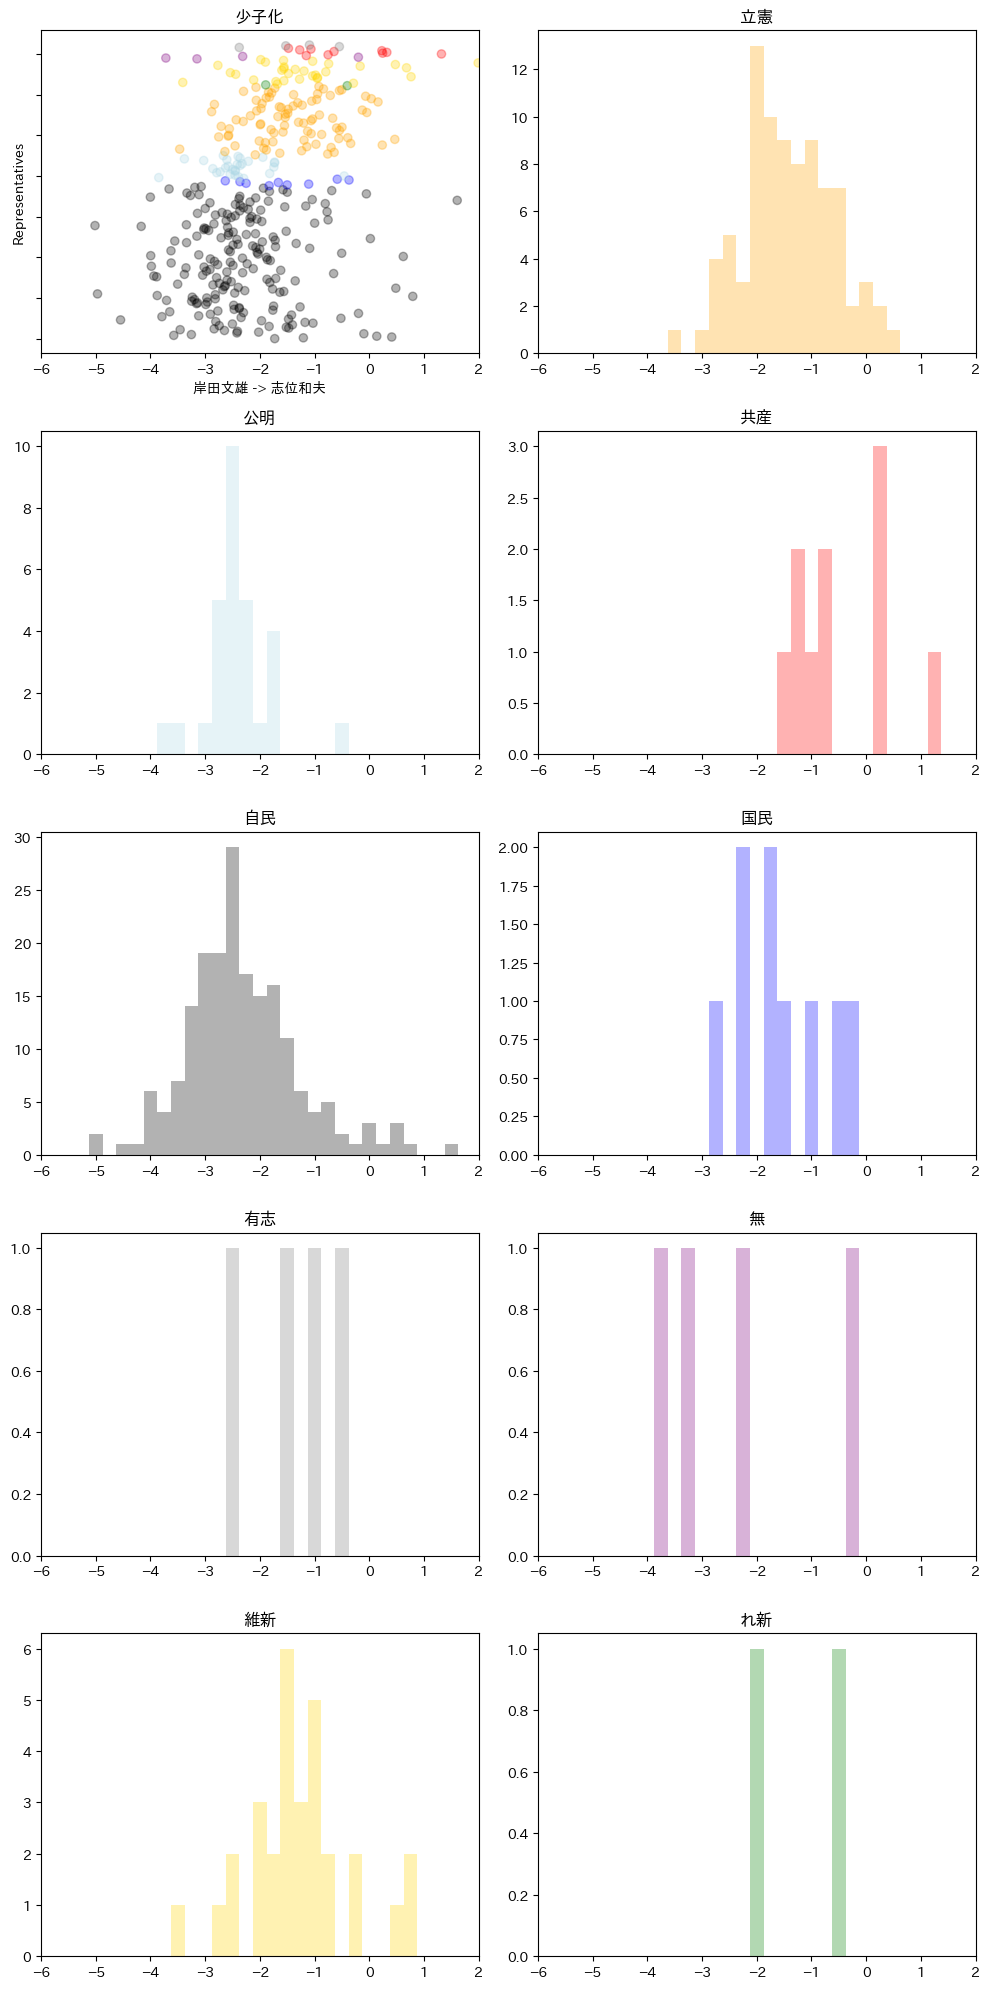

In [72]:
for topic_config in EXPERIMENT_CONFIG:
	try:
		topic = topic_config['topic_name']
		print(f'Visualizing {topic}')
		for_repr_name = topic_config["repr_references"]["for"]
		against_repr_name = topic_config["repr_references"]["against"]
		gen_for_sentence = topic_config["generated_references"]["for"]
		gen_against_sentence = topic_config["generated_references"]["against"]
		projections, reprs = vo.collapse_vectors_onto_two_ref_reprs(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'),
																	topic=topic,
																	ref_repr1=for_repr_name,
																	ref_repr2=against_repr_name)
		parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]

		psv.visualize(xs=projections,
					labels=reprs,
					colors=[PARTY_TO_COLOR[party] for party in parties],
					parties=parties,
					title=topic,
					xlabel=f'{for_repr_name} -> {against_repr_name}',
					path=os.path.join(DATA_DIR, "plots" ,f'{topic}.png')
					)
		projections, reprs = vo.collapse_vectors_onto_two_genenerated_strings(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'),
																			topic=topic,
																			string1=gen_for_sentence,
																			string2=gen_against_sentence)
		parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]

		psv.visualize(xs=projections,
					labels=reprs,
					colors=[PARTY_TO_COLOR[party] for party in parties],
					parties=parties,
					title=topic,
					xlabel=f'for -> against',
					path=os.path.join(DATA_DIR, "plots" ,f'{topic}_gen.png')
					)
		
		

	except Exception as e:
		print(e)
		continue
	

## 6. Reduce dimensionality and visualize everything on 2D plane

In [76]:
for topic_config in EXPERIMENT_CONFIG:
	try:
		topic = topic_config['topic_name']
		print(f'Visualizing {topic}')
		for_repr_name = topic_config["repr_references"]["for"]
		against_repr_name = topic_config["repr_references"]["against"]
		gen_for_sentence = topic_config["generated_references"]["for"]
		gen_against_sentence = topic_config["generated_references"]["against"]
		embeddings, reprs = vo.get_embeddings_and_reprs(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'))
		
		#first generating umap with reference representatives
		red_embedings = vo.reduce_dimensions_umap(embeddings, n_components=2)
		parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]
		colors = [PARTY_TO_COLOR[party] for party in parties]
		for_repr_idx = reprs.index(for_repr_name)
		against_repr_idx = reprs.index(against_repr_name)
		psv.visualize_red_dimension(red_embedings, reprs, topic, parties, colors, for_repr_idx=for_repr_idx, against_repr_idx=against_repr_idx, path=os.path.join(DATA_DIR, "plots" ,f'{topic}_umap.png'), title=f'Political stance for {topic} with ref representatives')
		
		#now generating umap with generated sentences
		gen_for_embedding = st.encode(gen_for_sentence, convert_to_tensor=True, show_progress_bar=True)
		gen_against_embedding = st.encode(gen_against_sentence, convert_to_tensor=True, show_progress_bar=True)
		gen_for_embedding = gen_for_embedding.cpu().numpy()
		gen_against_embedding = gen_against_embedding.cpu().numpy()
		extended_embeddings = np.concatenate((embeddings, [gen_for_embedding, gen_against_embedding]), axis=0)
		extended_reprs = reprs + [gen_for_sentence, gen_against_sentence]
		extended_red_embeddings = vo.reduce_dimensions_umap(extended_embeddings, n_components=2)
		extended_parties = parties + ['', '']
		extended_colors = colors + ['brown', 'brown']
		gen_for_idx = extended_reprs.index(gen_for_sentence)
		gen_against_idx = extended_reprs.index(gen_against_sentence)
		psv.visualize_red_dimension(extended_red_embeddings, extended_reprs, topic, extended_parties, extended_colors, for_repr_idx=gen_for_idx, against_repr_idx=gen_against_idx, path=os.path.join(DATA_DIR, "plots" ,f'{topic}_umap_gen.png'), title=f'Political stance for {topic} with generated sentences')
	except Exception as e:
		print(e)
		continue
	

Visualizing 防衛
UMAP(n_neighbors=30, verbose=True)
Tue Dec 19 19:11:04 2023 Construct fuzzy simplicial set
Tue Dec 19 19:11:04 2023 Finding Nearest Neighbors
Tue Dec 19 19:11:04 2023 Finished Nearest Neighbor Search
Tue Dec 19 19:11:04 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   5%| ▌          26/500 [00:01]

	completed  0  /  500 epochs


Epochs completed:  13%| █▎         67/500 [00:01]

	completed  50  /  500 epochs


Epochs completed:  26%| ██▌        130/500 [00:02]

	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  43%| ████▎      214/500 [00:02]

	completed  200  /  500 epochs


Epochs completed:  58%| █████▊     292/500 [00:03]

	completed  250  /  500 epochs
	completed  300  /  500 epochs


Epochs completed:  76%| ███████▌   378/500 [00:03]

	completed  350  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:03]

	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Dec 19 19:11:08 2023 Finished embedding



Batches: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


UMAP(n_neighbors=30, verbose=True)
Tue Dec 19 19:11:08 2023 Construct fuzzy simplicial set
Tue Dec 19 19:11:08 2023 Finding Nearest Neighbors
Tue Dec 19 19:11:08 2023 Finished Nearest Neighbor Search
Tue Dec 19 19:11:08 2023 Construct embedding


Epochs completed:  14%| █▍         69/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  59%| █████▊     293/500 [00:02]

	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  72%| ███████▏   360/500 [00:02]

	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]

	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Dec 19 19:11:11 2023 Finished embedding


Visualizing 少子化
UMAP(n_neighbors=30, verbose=True)
Tue Dec 19 19:11:11 2023 Construct fuzzy simplicial set
Tue Dec 19 19:11:11 2023 Finding Nearest Neighbors
Tue Dec 19 19:11:11 2023 Finished Nearest Neighbor Search
Tue Dec 19 19:11:11 2023 Construct embedding


Epochs completed:  28%| ██▊        142/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  55%| █████▌     275/500 [00:01]

	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  83%| ████████▎  414/500 [00:02]

	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]


	completed  450  /  500 epochs
Tue Dec 19 19:11:13 2023 Finished embedding


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


UMAP(n_neighbors=30, verbose=True)
Tue Dec 19 19:11:14 2023 Construct fuzzy simplicial set
Tue Dec 19 19:11:14 2023 Finding Nearest Neighbors
Tue Dec 19 19:11:14 2023 Finished Nearest Neighbor Search
Tue Dec 19 19:11:14 2023 Construct embedding


Epochs completed:  36%| ███▌       178/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  64%| ██████▎    318/500 [00:01]

	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]


	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Dec 19 19:11:16 2023 Finished embedding
Visualizing LGBTQ
UMAP(n_neighbors=30, verbose=True)
Tue Dec 19 19:11:16 2023 Construct fuzzy simplicial set
Tue Dec 19 19:11:16 2023 Finding Nearest Neighbors
Tue Dec 19 19:11:16 2023 Finished Nearest Neighbor Search
Tue Dec 19 19:11:16 2023 Construct embedding


Epochs completed:   8%| ▊          42/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs


Epochs completed:  28%| ██▊        140/500 [00:02]

	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  52%| █████▏     261/500 [00:02]

	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]

	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Dec 19 19:11:19 2023 Finished embedding
'志位和夫' is not in list
Visualizing 原発
UMAP(n_neighbors=30, verbose=True)
Tue Dec 19 19:11:19 2023 Construct fuzzy simplicial set


Tue Dec 19 19:11:19 2023 Finding Nearest Neighbors
Tue Dec 19 19:11:19 2023 Finished Nearest Neighbor Search
Tue Dec 19 19:11:19 2023 Construct embedding


Epochs completed:   6%| ▌          30/500 [00:02]

	completed  0  /  500 epochs
	completed  50  /  500 epochs


Epochs completed:  40%| ███▉       199/500 [00:02]

	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  84%| ████████▎  418/500 [00:02]

	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]


	completed  450  /  500 epochs
Tue Dec 19 19:11:22 2023 Finished embedding


Batches: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


UMAP(n_neighbors=30, verbose=True)
Tue Dec 19 19:11:23 2023 Construct fuzzy simplicial set
Tue Dec 19 19:11:23 2023 Finding Nearest Neighbors
Tue Dec 19 19:11:23 2023 Finished Nearest Neighbor Search
Tue Dec 19 19:11:23 2023 Construct embedding


Epochs completed:  19%| █▊         93/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  48%| ████▊      240/500 [00:01]

	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  87%| ████████▋  437/500 [00:02]

	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Dec 19 19:11:25 2023 Finished embedding
Visualizing 気候変動
UMAP(n_neighbors=30, verbose=True)
Tue Dec 19 19:11:25 2023 Construct fuzzy simplicial set
Tue Dec 19 19:11:26 2023 Finding Nearest Neighbors
Tue Dec 19 19:11:26 2023 Finished Nearest Neighbor Search
Tue Dec 19 19:11:26 2023 Construct embedding


Epochs completed:  12%| █▏         62/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  56%| █████▌     278/500 [00:02]

	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]


	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Dec 19 19:11:28 2023 Finished embedding


Batches: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


UMAP(n_neighbors=30, verbose=True)
Tue Dec 19 19:11:28 2023 Construct fuzzy simplicial set
Tue Dec 19 19:11:29 2023 Finding Nearest Neighbors
Tue Dec 19 19:11:29 2023 Finished Nearest Neighbor Search
Tue Dec 19 19:11:29 2023 Construct embedding


Epochs completed:  37%| ███▋       184/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  66%| ██████▋    332/500 [00:01]

	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]

	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Tue Dec 19 19:11:31 2023 Finished embedding
Visualizing 経済対策
'for'


# Topic Modelling on Politicians 

## 1. Group politicians based on position on the axis  

In [ ]:
# definitions 
    # group is the part of the axes 
    # party is the political party
    # rep is the representative (i.e., politician name)

# a. Divide the axis into n parts
n = 3

axis_range = np.max(projections) - np.min(projections) # TODO: possibly re-adjust the range to reflect the range in the viz?
portion_size = axis_range / n
dividing_points = [np.min(projections) + i * portion_size for i in range(1, 3)]

# b. Group politicians based on their position on the axis 
groups = np.digitize(projections, dividing_points)

# c. Add politician and party to dict # group 1, 2, 3 (from left to right)
group_dict = {group_num: {'politicians': [], 'parties': set()} for group_num in range(1, 4)}

for rep, group, party in zip(reprs, groups, parties):
    group_dict[group + 1]['politicians'].append(rep) # added +1 because of zero indexing 
    group_dict[group + 1]['parties'].add(party)

group_dict

## 2. Get the opinion sentences of each group on the axes

In [ ]:
from bertopic import BERTopic

topic = '少子化'

def text_preprocessing(texts):
    processed_texts = []
    for text in texts:
        # remove specific characters using re.sub
        text = re.sub('[、\r\n\u3000]', '', text)
        processed_texts.append(text)
    return processed_texts

group_topics = {}
group_dict_2 = group_dict.copy() # copy because cannot change size while we iterate

for group_num, group_info in group_dict.items():
    opinion_sentences = []
    
    for politician in group_info['politicians']:
        embeddings, dates, opinions = eh.get_embeddings_for_repr_for_topic(politician, topic)
        opinion_sentences.extend(opinions)

    #preprocess
    preprocessed_opinions = text_preprocessing(opinion_sentences)
    group_dict_2[group_num]['opinions_text'] = preprocessed_opinions

## 3. Topic Model

### BERTopic

In [ ]:
# TODO: fixing stopwords to get rid of unwanted common ideas

import MeCab
from sklearn.feature_extraction.text import CountVectorizer

mecab = MeCab.Tagger('-Owakati')

def tokenize_jp(text):
    text = re.sub('[、\r\n\u3000]', '', text)

    # Read stopwords from file
    with open('stopwords-ja.txt', encoding='utf-8') as f:
        stopwords = set(f.read().split())
    
    words = MeCab.Tagger("-Owakati").parse(text).split()
    
    # Remove stopwords from words
    words = [w for w in words if w not in stopwords] # TODO: find a comprehensive list of jp stopwords to make sure we get more sensical topic outputs
    
    return words

## test tockenizer 
# test = "今後も言語モデルの発展に伴って付け替え可能。文書のクラスタリングUMAPで次元削減した後、 HDBSCANでクラスタリング。次元削減手法やクラスタリング手法も付け替え可能。"
# tokenize_jp(test)

def apply_bertopic(group_dict: dict, group_num: int, nr_topics: int): # "cl-tohoku/bert-base-japanese-v3" has sentence embeddings as st
    MODEL_NAME = st #"sentence-transformers/paraphrase-multilingual-mpnet-base-v2"  # smaller model: "paraphrase-multilingual-MiniLM-L12-v2"
    vectorizer_model = CountVectorizer(tokenizer=tokenize_jp)
    model = BERTopic(verbose="True", embedding_model=MODEL_NAME, nr_topics=nr_topics, vectorizer_model=vectorizer_model) 
    
    topics, probs  = model.fit_transform(group_dict[group_num]['opinions_text'])
    
    return model

group_1 = apply_bertopic(group_dict_2, 1, 10)
# group_2 = apply_bertopic(2, 10)
# group_3 = apply_bertopic(3, 10)

In [ ]:
display(group_1.get_topic_info())
# display(group_2.get_topic_info())
# display(group_3.get_topic_info())

In [ ]:
group_1.visualize_barchart(n_words=10)
# group_1.visualize_topics()
# group_1.get_topics()
# group_1.get_topic(3)

### LDA (would need fixing)

In [ ]:
# import re 
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.pipeline import make_pipeline

# topic = '少子化'

# num_topics = 5 


# mecab = MeCab.Tagger('-Owakati')
# def tokenize_jp(text):
#     text = re.sub('[、\r\n\u3000]', '', text)

#     # Read stopwords from file
#     with open('stopwords-ja.txt', encoding='utf-8') as f:
#         stopwords = set(f.read().split())
    
#     words = MeCab.Tagger("-Owakati").parse(text).split()
    
#     # Remove stopwords from words
#     words = [w for w in words if w not in stopwords]
    
#     return words


# lda_model = make_pipeline(CountVectorizer(analyzer=tokenize_jp), LatentDirichletAllocation(n_components=num_topics, random_state=42))

# group_topics = {}

# # retrieve opinion sentences
# for group_num, group_info in group_dict.items():
#     opinion_sentences = []
    
#     for politician in group_info['politicians']:
#         embeddings, dates, opinions = eh.get_embeddings_for_repr_for_topic(politician, '少子化')
#         opinion_sentences.extend(opinions)

#     # fit LDA on the opinion sentences
#     lda_model.fit(opinion_sentences)
    
#     # get topics and their associated words
#     feature_names = lda_model.named_steps['countvectorizer'].get_feature_names_out()
#     topics = []
#     for topic_idx, topic in enumerate(lda_model.named_steps['latentdirichletallocation'].components_):
#         topic_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
#         topics.append(topic_words)
    
#     group_topics[group_num] = topics

In [ ]:
group_topics